<font size=5 >Credit Card Approval Prediction Using Sklearn</font>

# Import Required Libraries

In [285]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [286]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier


# Def Funtion will be used

In [385]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report_train = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        accuracy = accuracy_score(label, prediction)
        f1score = f1_score(label, prediction)
        recallscore = recall_score(label, prediction, average='weighted')
        precisionscore = precision_score(label, prediction, average='weighted')

        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy * 100:.2f}%")
        print(f"F1 Score: {f1score * 100:.2f}%")
        print("_______________________________________________")


    elif not train:
        clf_report_test = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        accuracy = accuracy_score(label, prediction)
        f1score = f1_score(label, prediction)
        recallscore = recall_score(label, prediction, average='weighted')
        precisionscore = precision_score(label, prediction, average='weighted')

        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy * 100:.2f}%")
        print(f"F1 Score: {f1score * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report_test}")
        print("_______________________________________________")

        # Confusion Matrix for test
        cm_test = confusion_matrix(label, prediction)
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
        disp_test.plot(cmap=plt.cm.Blues)
        plt.title('Test Data Confusion Matrix')

        plt.grid(False)
        plt.tight_layout()
        plt.show()





In [288]:
# Define function to handle outliers
def handle_outliers(group):
    Q1_val = group.quantile(0.25)
    Q3_val = group.quantile(0.75)
    IQR_val = Q3_val - Q1_val

    # Calculate bounds for outliers
    lower_bound = Q1_val - 1.5 * IQR_val
    upper_bound = Q3_val + 1.5 * IQR_val

    # Cap outliers to the upper and lower bounds
    group[group < lower_bound] = lower_bound
    group[group > upper_bound] = upper_bound

    return group

In [289]:
def create_summary(models, f1_scores, accuracies,recall, precision):
    summary = {
        'Models': models,
        'Accuracy': [f'{acc:.3f}%' for acc in accuracies],
        'F1 Score': [f'{score:.3f}%' for score in f1_scores],
        'Recall': [f'{acc:.3f}%' for acc in recall],
        'Precision': [f'{score:.3f}%' for score in precision],
    }
    df_summary = pd.DataFrame(summary)
    return df_summary

In [290]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [291]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut

    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [292]:
data = pd.read_csv("/content/drive/MyDrive/Final project /Data/application_record.csv", encoding = 'utf-8')
record = pd.read_csv("/content/drive/MyDrive/Final project /Data/credit_record.csv", encoding = 'utf-8')
data.shape , record.shape

((438557, 18), (1048575, 3))

In [293]:
plt.rcParams['figure.facecolor'] = 'white'

# Vintage Analysis

In [294]:
credit= record.copy()

In [295]:

grouped = credit.groupby('ID')
#convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit0 = credit.copy()
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

#denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

#ventage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']})
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum']
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [296]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()

vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


In [297]:
# Using pivot to convert long data to wide data:
# Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,...,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,...,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53,0.00000,0.002028,0.002028,0.002028,0.004057,0.004057,0.008114,0.010142,0.010142,0.012170,...,0.028398,0.028398,0.028398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-52,0.00000,0.000000,0.007233,0.009042,0.009042,0.009042,0.012658,0.012658,0.014467,0.016275,...,0.023508,0.023508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


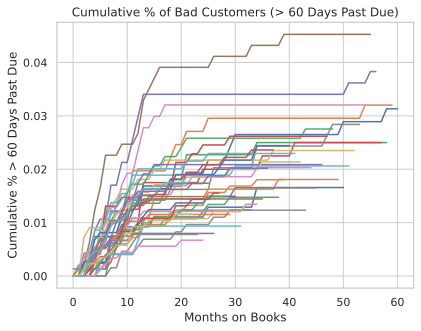

In [298]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

# Feature Engineering

## Response Variable

In [299]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'})
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

Generally, users in risk should be in 3%, thus I choose users who overdue for more than 60 days as target risk users. Those samples are marked as '1', else are '0'.

In [300]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes'
record['dep_value'][record['STATUS'] =='3']='Yes'
record['dep_value'][record['STATUS'] =='4']='Yes'
record['dep_value'][record['STATUS'] =='5']='Yes'

In [301]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

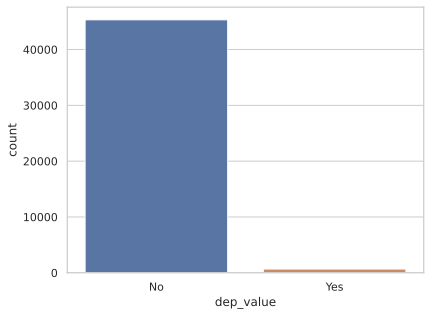

In [302]:
sns.countplot(x=cpunt["dep_value"]),
cpunt['dep_value'].value_counts(normalize=True)

## Features

+ rename

In [303]:
new_data.rename(columns={'CODE_GENDER':'Gender', 'FLAG_OWN_CAR':'Car', 'FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChildNo', 'AMT_INCOME_TOTAL':'Income',
                         'NAME_EDUCATION_TYPE':'EducationType', 'NAME_FAMILY_STATUS':'Martial_status',
                         'NAME_HOUSING_TYPE':'HousingType', 'FLAG_EMAIL':'Email',
                         'NAME_INCOME_TYPE':'IncomeType', 'FLAG_WORK_PHONE':'WorkPhone',
                         'FLAG_PHONE':'Phone', 'CNT_FAM_MEMBERS':'FamilySize',
                         'OCCUPATION_TYPE':'OccupationType'
                        }, inplace=True)


In [304]:
new_data[['ID','ChildNo','Income','DAYS_BIRTH','DAYS_EMPLOYED','begin_month']].describe().T

,count,mean,std,min,25%,50%,75%,max
ID,36457.0,5.078227e+06,41875.240788,5008804.0,5042028.0,5074614.0,5115396.0,5150487.0
ChildNo,36457.0,4.303152e-01,0.742367,0.0,0.0,0.0,1.0,19.0
Income,36457.0,1.866857e+05,101789.226482,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,36457.0,-1.597517e+04,4200.549944,-25152.0,-19438.0,-15563.0,-12462.0,-7489.0
DAYS_EMPLOYED,36457.0,5.926294e+04,137651.334859,-15713.0,-3153.0,-1552.0,-408.0,365243.0
begin_month,36457.0,-2.616419e+01,16.501854,-60.0,-39.0,-24.0,-12.0,0.0


In [305]:
new_data.isnull().sum()

ID                    0
Gender                0
Car                   0
Reality               0
ChildNo               0
Income                0
IncomeType            0
EducationType         0
Martial_status        0
HousingType           0
DAYS_BIRTH            0
DAYS_EMPLOYED         0
FLAG_MOBIL            0
WorkPhone             0
Phone                 0
Email                 0
OccupationType    11323
FamilySize            0
begin_month           0
dep_value             0
target                0
dtype: int64

In [306]:
total_missing = new_data.isnull().sum().sum()
total_values = len(new_data)
percentage_missing = round((total_missing / total_values) * 100, 2)

# Print the percentage
print("Percentage of missing values:", percentage_missing, "%")

Percentage of missing values: 31.06 %


In [307]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()

In [308]:
new_data.shape

(25134, 21)

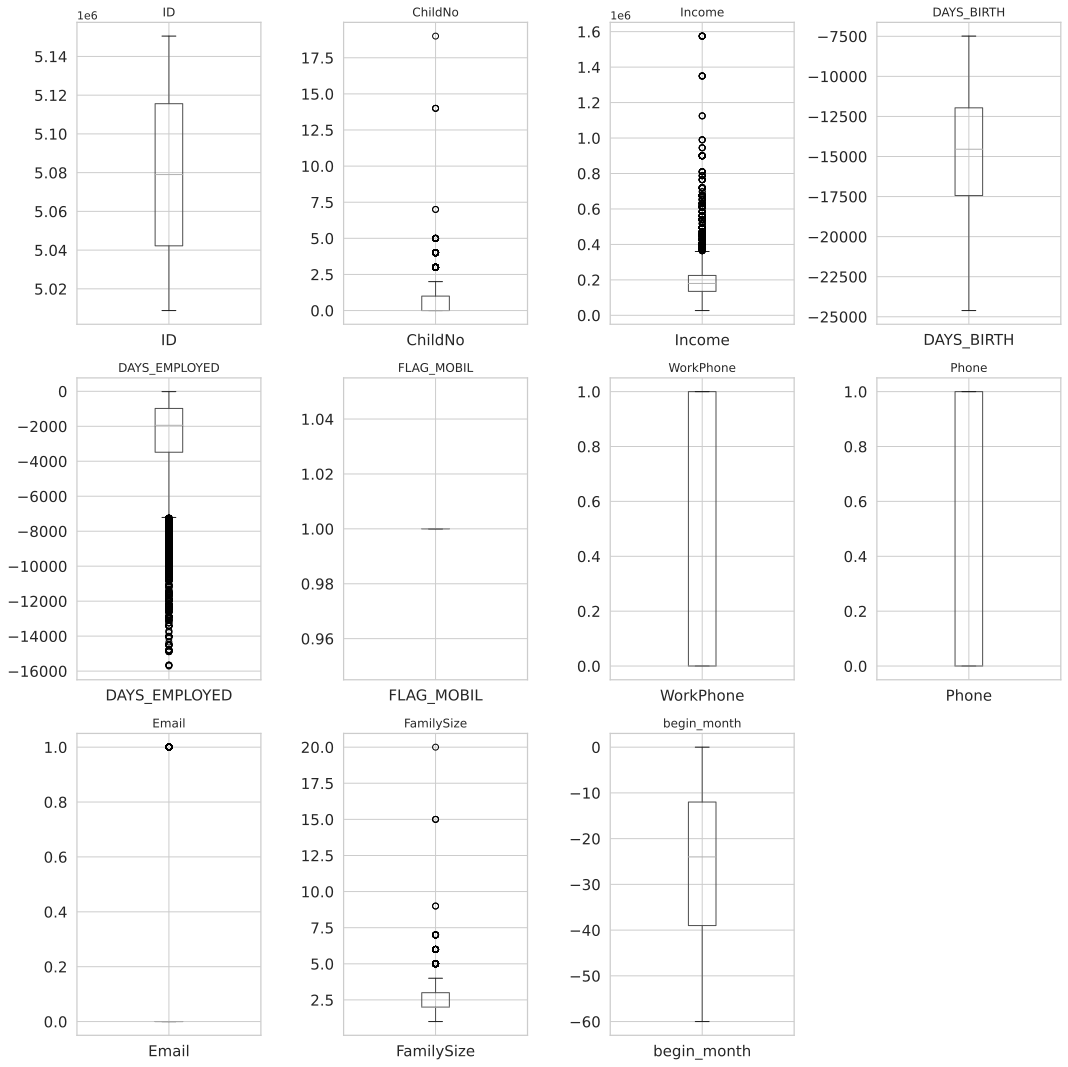

In [309]:
# Select numerical columns (excluding object type)
not_object = new_data.select_dtypes(exclude=object).columns
# Calculate the number of rows and columns for subplots
n_rows = len(not_object) // 4 + (len(not_object) % 4 > 0)
n_cols = 4

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes if needed
axes = axes.flatten()

# Loop through numerical columns and plot boxplots
for idx, column in enumerate(not_object):
    new_data[[column]].boxplot(fontsize=15, ax=axes[idx])
    axes[idx].set_title(column)  # Set title for each subplot

# Remove any unused subplots
for idx in range(len(not_object), n_rows * n_cols):
    fig.delaxes(axes[idx])

# Adjust layout to prevent overlap
plt.tight_layout()

In [310]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

### Binary Features

#### target

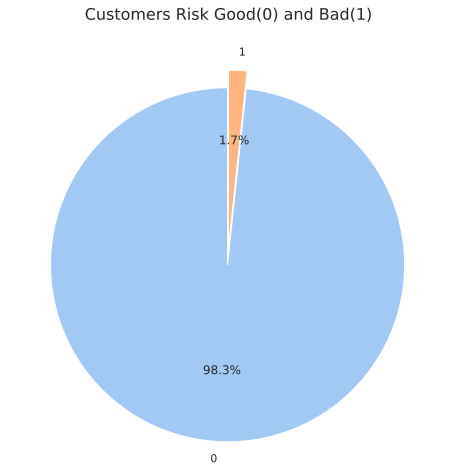

In [311]:
# Example data
counts = new_data["target"].value_counts()
percentages = counts / len(data) * 100

# Set Seaborn style
sns.set(style="whitegrid")

# Identify the index of the slice you want to explode
explode_index = 0

# Create the pie chart with explosion
plt.figure(figsize=(10, 8))
colors = sns.color_palette("pastel")
explode = [0.1 if i == explode_index else 0 for i in range(len(counts))]
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90, colors=colors, explode=explode)

plt.title("Customers Risk Good(0) and Bad(1)", fontsize=16)

# Show the plot
plt.show()

#### Gender

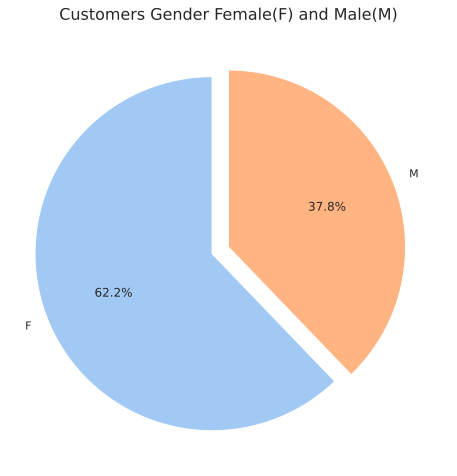

In [312]:
# Example data
counts = new_data["Gender"].value_counts()
percentages = counts / len(data) * 100

# Set Seaborn style
sns.set(style="whitegrid")

# Identify the index of the slice you want to explode
explode_index = 0

# Create the pie chart with explosion
plt.figure(figsize=(10, 8))
colors = sns.color_palette("pastel")
explode = [0.1 if i == explode_index else 0 for i in range(len(counts))]
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90, colors=colors, explode=explode)

plt.title("Customers Gender Female(F) and Male(M)", fontsize=16)

# Show the plot
plt.show()

In [313]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
This variable's IV is: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


#### Having a car or not

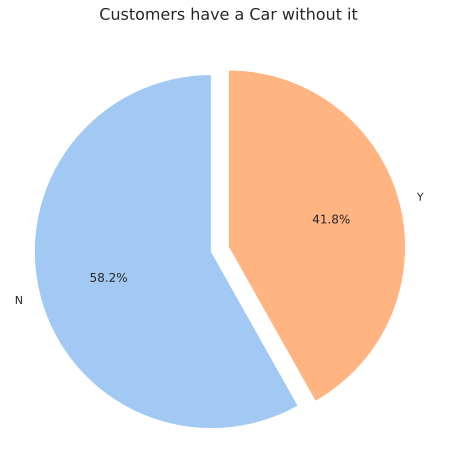

In [314]:
# Example data
counts = new_data["Car"].value_counts()
percentages = counts / len(data) * 100

# Set Seaborn style
sns.set(style="whitegrid")

# Identify the index of the slice you want to explode
explode_index = 0

# Create the pie chart with explosion
plt.figure(figsize=(8, 8))
colors = sns.color_palette("pastel")
explode = [0.1 if i == explode_index else 0 for i in range(len(counts))]
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90, colors=colors, explode=explode)

plt.title("Customers have a Car without it", fontsize=16)

# Show the plot
plt.show()

In [315]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
This variable's IV is: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


#### Having house reality or not

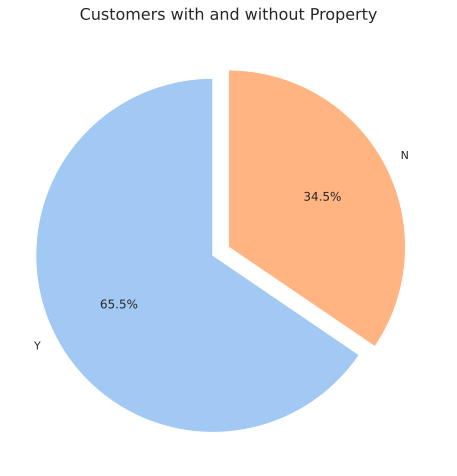

In [316]:
# Example data
counts = new_data["Reality"].value_counts()
percentages = counts / len(data) * 100

# Set Seaborn style
sns.set(style="whitegrid")

# Identify the index of the slice you want to explode
explode_index = 0

# Create the pie chart with explosion
plt.figure(figsize=(10, 8))
colors = sns.color_palette("pastel")
explode = [0.1 if i == explode_index else 0 for i in range(len(counts))]
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90, colors=colors, explode=explode)

plt.title("Customers with and without Property", fontsize=16)

# Show the plot
plt.show()

In [317]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64
This variable's IV is: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


#### Having a phone or not

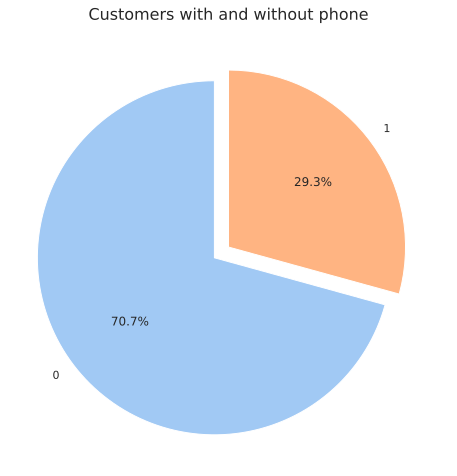

In [318]:
# Example data
counts = new_data["Phone"].value_counts()
percentages = counts / len(data) * 100

# Set Seaborn style
sns.set(style="whitegrid")

# Identify the index of the slice you want to explode
explode_index = 0

# Create the pie chart with explosion
plt.figure(figsize=(10, 8))
colors = sns.color_palette("pastel")
explode = [0.1 if i == explode_index else 0 for i in range(len(counts))]
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90, colors=colors, explode=explode)

plt.title("Customers with and without phone", fontsize=16)

# Show the plot
plt.show()

In [319]:
new_data['Phone']=new_data['Phone'].astype(str)
print(new_data['Phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['Phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'Phone','target')
ivtable.loc[ivtable['variable']=='Phone','IV']=iv
data.head()

0    0.707209
1    0.292791
Name: Phone, dtype: float64
This variable's IV is: 0.0005480495762639297
0    17775
1     7359
Name: Phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,Phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


#### Having an email or not

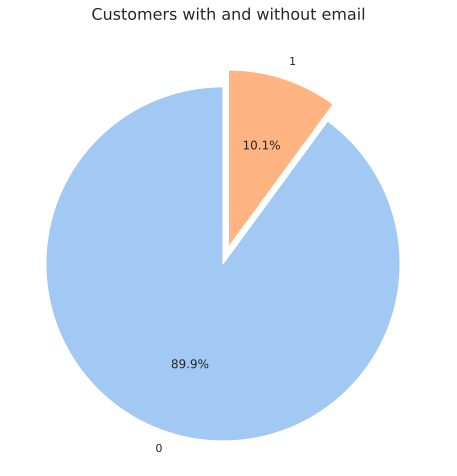

In [320]:
# Example data
counts = new_data["Email"].value_counts()
percentages = counts / len(data) * 100

# Set Seaborn style
sns.set(style="whitegrid")

# Identify the index of the slice you want to explode
explode_index = 0

# Create the pie chart with explosion
plt.figure(figsize=(10, 8))
colors = sns.color_palette("pastel")
explode = [0.1 if i == explode_index else 0 for i in range(len(counts))]
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90, colors=colors, explode=explode)

plt.title("Customers with and without email", fontsize=16)

# Show the plot
plt.show()

In [321]:
print(new_data['Email'].value_counts(normalize=True,sort=False))
new_data['Email']=new_data['Email'].astype(str)
iv, data=calc_iv(new_data,'Email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: Email, dtype: float64
This variable's IV is: 1.7343581493999816e-05
0    22604
1     2530
Name: Email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,Email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


#### Having a Work Phone or not

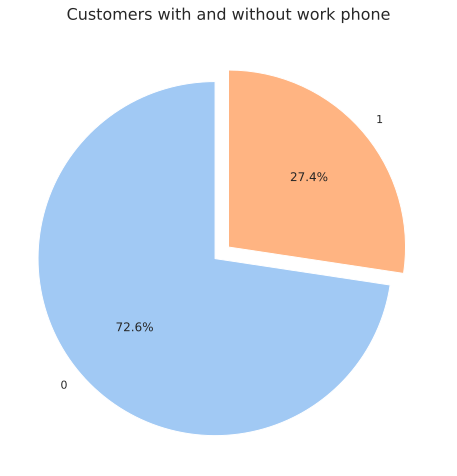

In [322]:
# Example data
counts = new_data["WorkPhone"].value_counts()
percentages = counts / len(data) * 100

# Set Seaborn style
sns.set(style="whitegrid")

# Identify the index of the slice you want to explode
explode_index = 0

# Create the pie chart with explosion
plt.figure(figsize=(10, 8))
colors = sns.color_palette("pastel")
explode = [0.1 if i == explode_index else 0 for i in range(len(counts))]
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90, colors=colors, explode=explode)

plt.title("Customers with and without work phone", fontsize=16)

# Show the plot
plt.show()

In [323]:
new_data['WorkPhone']=new_data['WorkPhone'].astype(str)
iv, data = calc_iv(new_data,'WorkPhone','target')
new_data.drop(new_data[new_data['WorkPhone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='WorkPhone','IV']=iv
data.head()

This variable's IV is: 0.002042429795148461
0    18252
1     6882
Name: WorkPhone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,WorkPhone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,WorkPhone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


### Continuous Variables

#### Children Numbers

In [324]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'ChildNo', 'Income', 'IncomeType',
       'EducationType', 'Martial_status', 'HousingType', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'WorkPhone', 'Phone', 'Email',
       'OccupationType', 'FamilySize', 'begin_month', 'dep_value', 'target'],
      dtype='object')

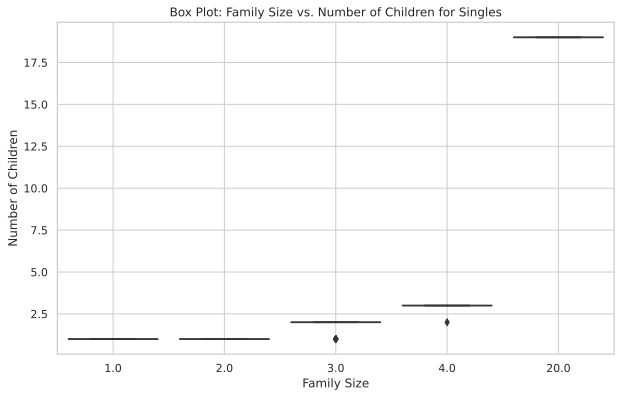

In [325]:
# Filter the data where 'Marital_status' is 'Single / not married' and 'NO_Childern' is >= 0
condition_to_Single = (new_data['Martial_status'] == 'Single / not married') & (new_data['ChildNo'] > 0)
filtered_data = new_data[condition_to_Single]

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='FamilySize', y='ChildNo', data=filtered_data, palette='viridis')
plt.title('Box Plot: Family Size vs. Number of Children for Singles')
plt.xlabel('Family Size')
plt.ylabel('Number of Children')
plt.grid(True)  # Add grid lines for better readability
plt.show()

In [326]:
# Replace 'NO_Childern' values with 0 for the filtered rows
new_data.loc[condition_to_Single, 'Martial_status'] = 'Married'

<Figure size 1000x600 with 0 Axes>

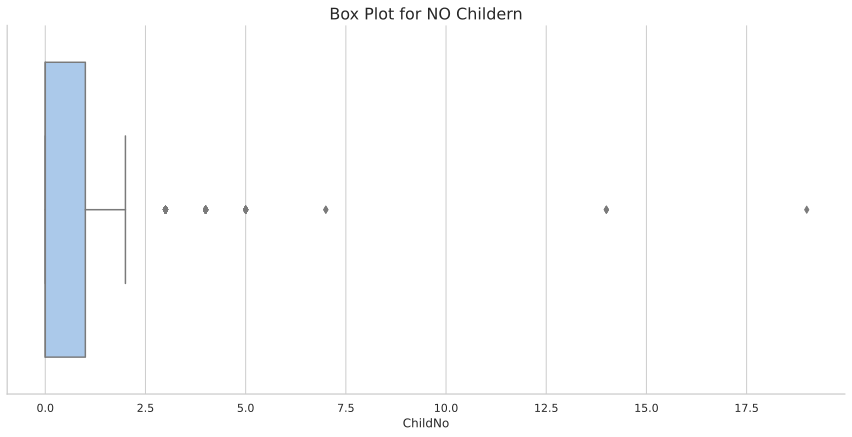

In [327]:
# Create a box plot using catplot
plt.figure(figsize=(10, 6))
sns.catplot(x='ChildNo', kind='box', data=new_data, height=6, aspect=2, palette="pastel")
plt.title("Box Plot for NO Childern", fontsize=16)

# Show the plot
plt.show()

In [328]:
# Assuming new_data is your DataFrame
# Calculate the median value of the 'ChildNo' column
median_value = np.median(new_data['ChildNo'])

# Calculate the interquartile range (IQR) for the 'ChildNo' column
Q1 = new_data['ChildNo'].quantile(0.25)
Q3 = new_data['ChildNo'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold and bounds for outliers
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Replace outliers with the median value for the 'ChildNo' column
new_data['ChildNo'] = np.where(
    (new_data['ChildNo'] < lower_bound) | (new_data['ChildNo'] > upper_bound),
    median_value,
    new_data['ChildNo']
)

In [329]:
new_data['ChildNoegp']=new_data['ChildNo']
new_data['ChildNoegp']=new_data['ChildNoegp'].astype(object)
new_data.loc[new_data['ChildNoegp']>= 2,'ChildNoegp']='2More'
iv, data=calc_iv(new_data,'ChildNoegp','target')
ivtable.loc[ivtable['variable']=='ChildNo','IV']=iv
data.head()

This variable's IV is: 0.0037129193760631765
0.0      16301
1.0       6118
2More     2715
Name: ChildNoegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChildNoegp,0.0,16301,16016,285,0.648564,0.017484,0.648106,0.675355,-0.041185,0.001122
1,ChildNoegp,1.0,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChildNoegp,2More,2715,2675,40,0.108021,0.014733,0.108247,0.094787,0.132786,0.001787


#### Annual Income
bins the data based on sample quantiles

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: Income, dtype: int64


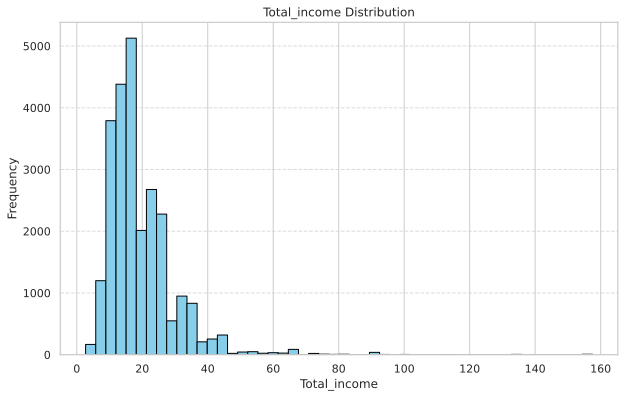

In [330]:
new_data['Income']=new_data['Income'].astype(object)
new_data['Income'] = new_data['Income']/10000
print(new_data['Income'].value_counts(bins=10,sort=False))
plt.figure(figsize=(10, 6))
plt.hist(new_data['Income'], bins=50, color='skyblue', edgecolor='black')
plt.title('Total_income Distribution')
plt.xlabel('Total_income')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1000x600 with 0 Axes>

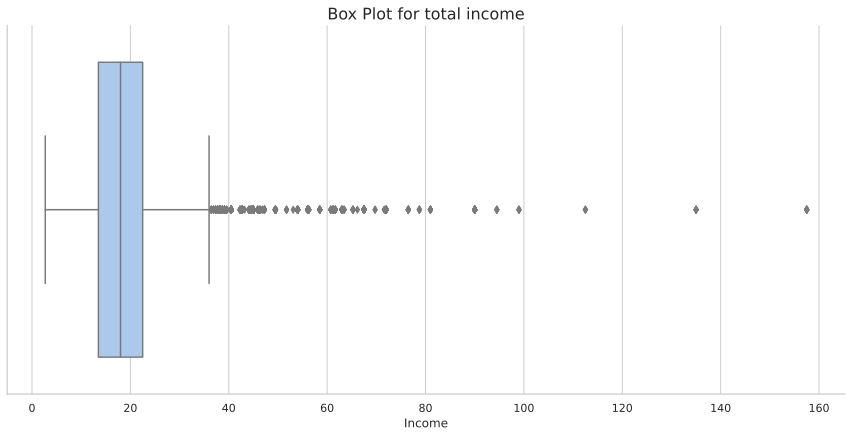

In [331]:
plt.figure(figsize=(10, 6))
sns.catplot(x='Income', kind='box', data=new_data, height=6, aspect=2, palette="pastel")
plt.title("Box Plot for total income", fontsize=16)

# Show the plot
plt.show()

In [332]:
# Assuming new_data is your DataFrame
# Calculate the median value of the 'Income' column
median_value = np.median(new_data['Income'])

# Calculate the interquartile range (IQR) for the 'Income' column
Q1 = new_data['Income'].quantile(0.25)
Q3 = new_data['Income'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold and bounds for outliers
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Replace outliers with the median value for the 'Income' column
new_data['Income'] = np.where(
    (new_data['Income'] < lower_bound) | (new_data['Income'] > upper_bound),
    median_value,
    new_data['Income']
)

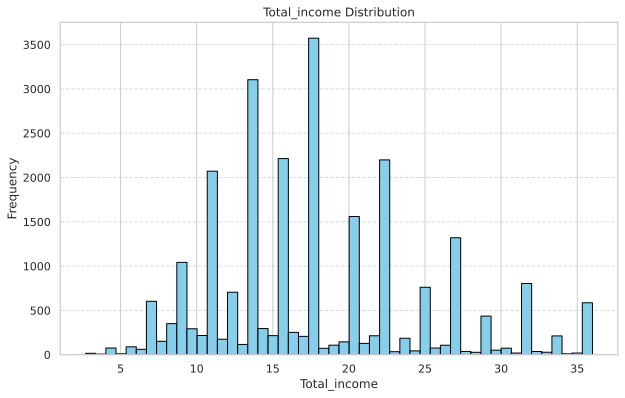

In [333]:
plt.figure(figsize=(10, 6))
plt.hist(new_data['Income'], bins=50, color='skyblue', edgecolor='black')
plt.title('Total_income Distribution')
plt.xlabel('Total_income')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [334]:
new_data = get_category(new_data,'Income',3, ["low","medium", "high"])
iv, data = calc_iv(new_data,'gp_Income','target')
ivtable.loc[ivtable['variable']=='Income','IV'] = iv
data.head()

This variable's IV is: 0.0015948343029934082
medium    12207
low        8996
high       3931
Name: gp_Income, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Income,high,3931,3859,72,0.156402,0.018316,0.156159,0.170616,-0.088542,0.001280
1,gp_Income,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_Income,medium,12207,12004,203,0.485677,0.016630,0.485756,0.481043,0.009750,0.000046


#### Age

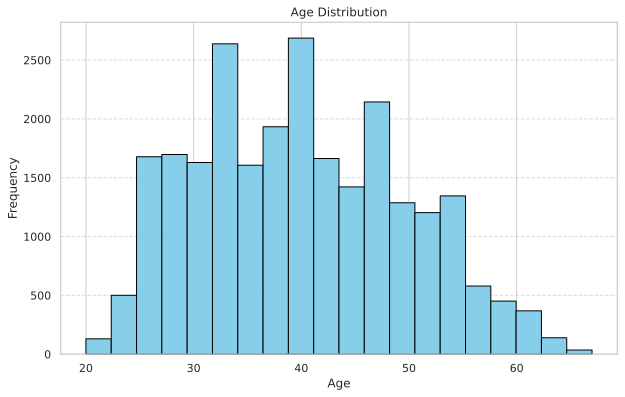

In [335]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365
plt.figure(figsize=(10, 6))
plt.hist(new_data['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1000x600 with 0 Axes>

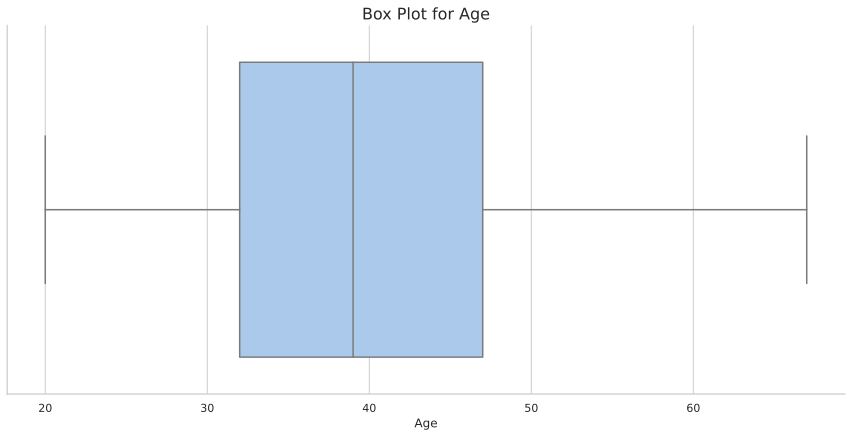

In [336]:
sns.set(style="whitegrid")

# Create a box plot using catplot
plt.figure(figsize=(10, 6))
sns.catplot(x='Age', kind='box', data=new_data, height=6, aspect=2, palette="pastel")
plt.title("Box Plot for Age", fontsize=16)

# Show the plot
plt.show()

In [337]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


#### Working Years

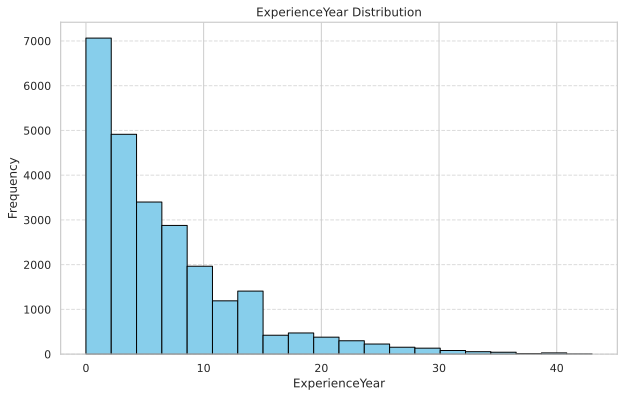

In [338]:
# Calculate work experience in years
new_data['worktm'] = -(new_data['DAYS_EMPLOYED']) // 365
new_data.loc[new_data['worktm'] < 0, 'worktm'] = np.nan
new_data['worktm'].fillna(new_data['worktm'].mean(), inplace=True)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(new_data['worktm'], bins=20, color='skyblue', edgecolor='black')
plt.title('ExperienceYear Distribution')
plt.xlabel('ExperienceYear')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Figure size 1000x600 with 0 Axes>

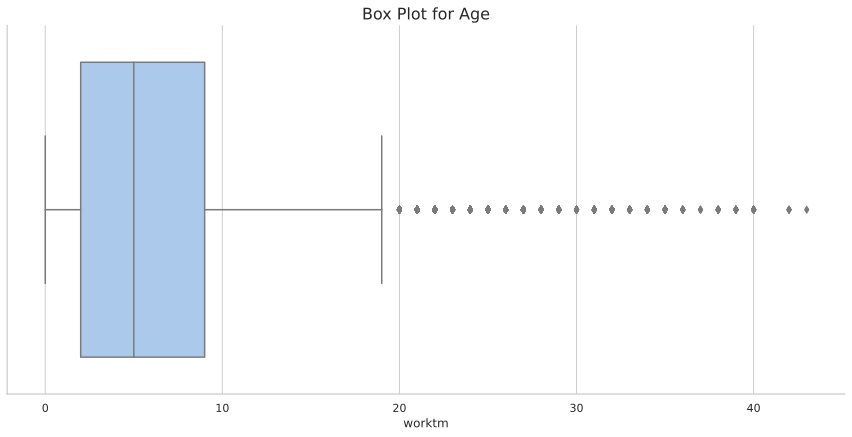

In [339]:
sns.set(style="whitegrid")

# Create a box plot using catplot
plt.figure(figsize=(10, 6))
sns.catplot(x='worktm', kind='box', data=new_data, height=6, aspect=2, palette="pastel")
plt.title("Box Plot for Age", fontsize=16)

# Show the plot
plt.show()

In [340]:
# Assuming new_data is your DataFrame
# Calculate the median value of the 'worktm' column
median_value = np.median(new_data['worktm'])

# Calculate the interquartile range (IQR) for the 'worktm' column
Q1 = new_data['worktm'].quantile(0.25)
Q3 = new_data['worktm'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold and bounds for outliers
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Replace outliers with the median value for the 'worktm' column
new_data['worktm'] = np.where(
    (new_data['worktm'] < lower_bound) | (new_data['worktm'] > upper_bound),
    median_value,
    new_data['worktm']
)

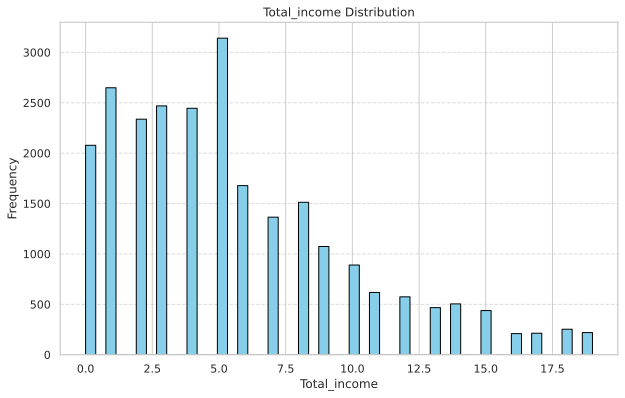

In [341]:
plt.figure(figsize=(10, 6))
plt.hist(new_data['worktm'], bins=50, color='skyblue', edgecolor='black')
plt.title('Total_income Distribution')
plt.xlabel('Total_income')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [342]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.09818376914551227
lowest     9533
low        8629
medium     4094
high       1983
highest     895
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,1983,1964,19,0.078897,0.009581,0.079476,0.045024,0.568261,0.019578
1,gp_worktm,highest,895,883,12,0.035609,0.013408,0.035732,0.028436,0.228380,0.001666
2,gp_worktm,low,8629,8524,105,0.343320,0.012168,0.344934,0.248815,0.326642,0.031396
3,gp_worktm,lowest,9533,9314,219,0.379287,0.022973,0.376902,0.518957,-0.319837,0.045435
4,gp_worktm,medium,4094,4027,67,0.162887,0.016365,0.162957,0.158768,0.026045,0.000109


#### Famliy Size

<Figure size 1000x600 with 0 Axes>

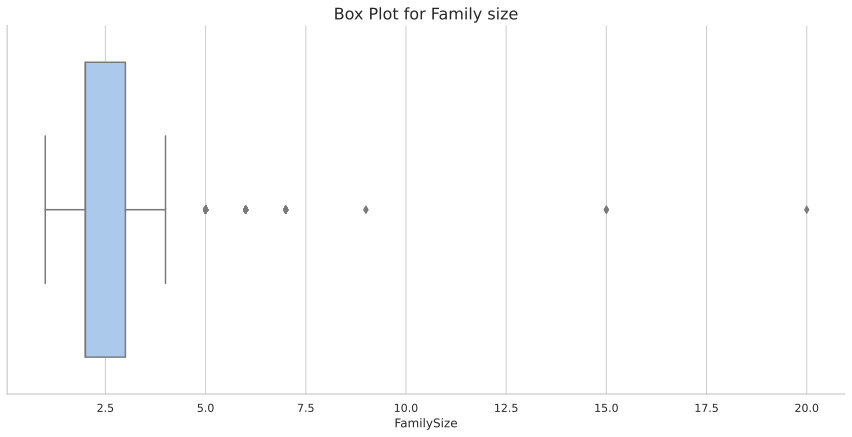

In [343]:
# Create a box plot using catplot
plt.figure(figsize=(10, 6))
sns.catplot(x='FamilySize', kind='box', data=new_data, height=6, aspect=2, palette="pastel")
plt.title("Box Plot for Family size", fontsize=16)

# Show the plot
plt.show()

In [344]:
# Assuming new_data is your DataFrame
# Calculate the median value of the 'FamilySize' column
median_value = np.median(new_data['FamilySize'])

# Calculate the interquartile range (IQR) for the 'FamilySize' column
Q1 = new_data['FamilySize'].quantile(0.25)
Q3 = new_data['FamilySize'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold and bounds for outliers
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Replace outliers with the median value for the 'FamilySize' column
new_data['FamilySize'] = np.where(
    (new_data['FamilySize'] < lower_bound) | (new_data['FamilySize'] > upper_bound),
    median_value,
    new_data['FamilySize']
)

In [345]:
new_data['FamilySize'].value_counts(sort=False)

2.0    13079
1.0     4263
3.0     5216
4.0     2576
Name: FamilySize, dtype: int64

In [346]:
new_data['famsizegp']=new_data['FamilySize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='FamilySize','IV']=iv
data.head()

This variable's IV is: 0.008125750039075303
2.0      13079
3more     7792
1.0       4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1.0,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2.0,13079,12859,220,0.520371,0.016821,0.520354,0.521327,-0.001867,0.000002
2,famsizegp,3more,7792,7674,118,0.310018,0.015144,0.310537,0.279621,0.104870,0.003242


In [347]:
#new_data = convert_dummy(new_data,'famsizegp')

### Categorical Features

#### Income Type

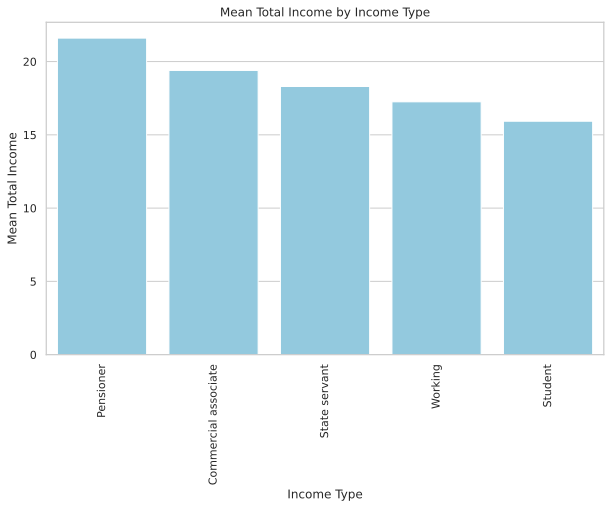

In [348]:
mean_income_by_IncomeType = new_data.groupby('IncomeType')['Income'].mean()
sorted_income = mean_income_by_IncomeType.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# Use sorted series for both x and y axes
sns.barplot(
    x=sorted_income.index,
    y=sorted_income.values,
    color='skyblue'
)

plt.xlabel('Income Type')
plt.ylabel('Mean Total Income')
plt.title('Mean Total Income by Income Type')
plt.xticks(rotation=90)
plt.show()


In [349]:
print(new_data['IncomeType'].value_counts(sort=False))
print(new_data['IncomeType'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['IncomeType']=='Pensioner','IncomeType']='State servant'
new_data.loc[new_data['IncomeType']=='Student','IncomeType']='State servant'
iv, data=calc_iv(new_data,'IncomeType','target')
ivtable.loc[ivtable['variable']=='IncomeType','IV']=iv
data.head()

Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: IncomeType, dtype: int64
Working                 0.621549
Commercial associate    0.280576
State servant           0.096960
Student                 0.000398
Pensioner               0.000517
Name: IncomeType, dtype: float64
This variable's IV is: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: IncomeType, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,IncomeType,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,IncomeType,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,IncomeType,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


#### Occupation Type

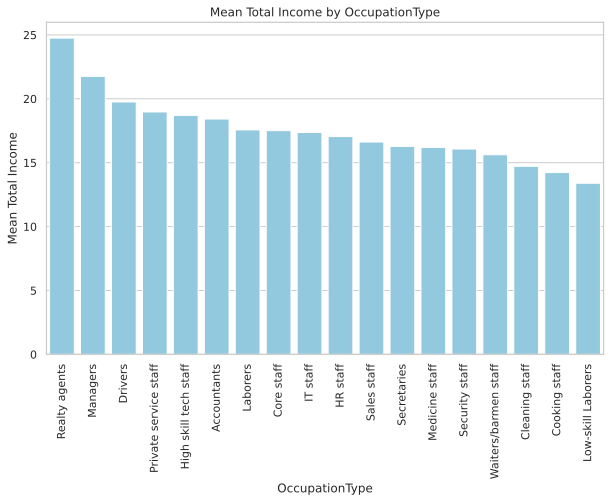

In [350]:
mean_income_by_OccupationType = new_data.groupby('OccupationType')['Income'].mean()
sorted_income = mean_income_by_OccupationType.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# Use sorted series for both x and y axes
sns.barplot(
    x=sorted_income.index,
    y=sorted_income.values,
    color='skyblue'
)

plt.xlabel('OccupationType')
plt.ylabel('Mean Total Income')
plt.title('Mean Total Income by OccupationType')
plt.xticks(rotation=90)
plt.show()


In [351]:
new_data.loc[(new_data['OccupationType']=='Cleaning staff') | (new_data['OccupationType']=='Cooking staff') | (new_data['OccupationType']=='Drivers') | (new_data['OccupationType']=='Laborers') | (new_data['OccupationType']=='Low-skill Laborers') | (new_data['OccupationType']=='Security staff') | (new_data['OccupationType']=='Waiters/barmen staff'),'OccupationType']='Laborwk'
new_data.loc[(new_data['OccupationType']=='Accountants') | (new_data['OccupationType']=='Core staff') | (new_data['OccupationType']=='HR staff') | (new_data['OccupationType']=='Medicine staff') | (new_data['OccupationType']=='Private service staff') | (new_data['OccupationType']=='Realty agents') | (new_data['OccupationType']=='Sales staff') | (new_data['OccupationType']=='Secretaries'),'OccupationType']='officewk'
new_data.loc[(new_data['OccupationType']=='Managers') | (new_data['OccupationType']=='High skill tech staff') | (new_data['OccupationType']=='IT staff'),'OccupationType']='hightecwk'
print(new_data['OccupationType'].value_counts())
iv, data=calc_iv(new_data,'OccupationType','target')
ivtable.loc[ivtable['variable']=='OccupationType','IV']=iv
data.head()

Laborwk      10496
officewk     10183
hightecwk     4455
Name: OccupationType, dtype: int64
This variable's IV is: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: OccupationType, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,OccupationType,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,OccupationType,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,OccupationType,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


#### House Type

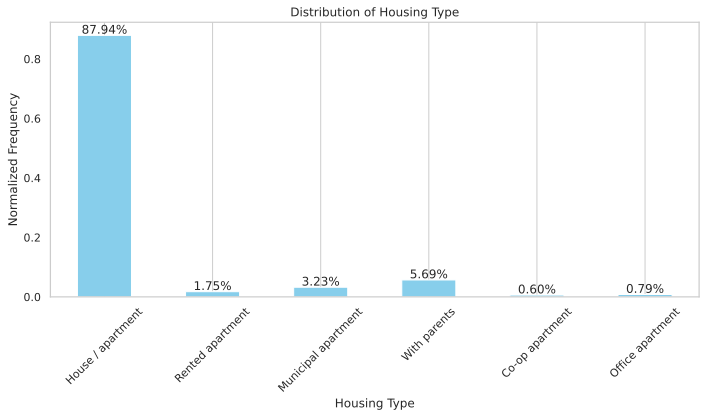

In [352]:
import matplotlib.pyplot as plt

# Assuming new_data is your DataFrame
HousingType_counts = new_data['HousingType'].value_counts(normalize=True, sort=False)

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
bars = HousingType_counts.plot(kind='bar', color='skyblue')  # Create the bar chart

# Add labels on the bars
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.2%'),
                 (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()),
                 ha='center',
                 va='center',
                 size=12,
                 xytext=(0, 5),
                 textcoords='offset points')

plt.title('Distribution of Housing Type')  # Set the title
plt.xlabel('Housing Type')  # Set the x-axis label
plt.ylabel('Normalized Frequency')  # Set the y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.grid(axis='y')  # Add gridlines on the y-axis
plt.tight_layout()  # Adjust layout to ensure labels and titles are displayed properly
plt.show()  # Display the plot


In [353]:
iv, data=calc_iv(new_data,'HousingType','target')
ivtable.loc[ivtable['variable']=='HousingType','IV']=iv
data.head()

This variable's IV is: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: HousingType, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,HousingType,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,HousingType,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,HousingType,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,HousingType,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,HousingType,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


#### Education

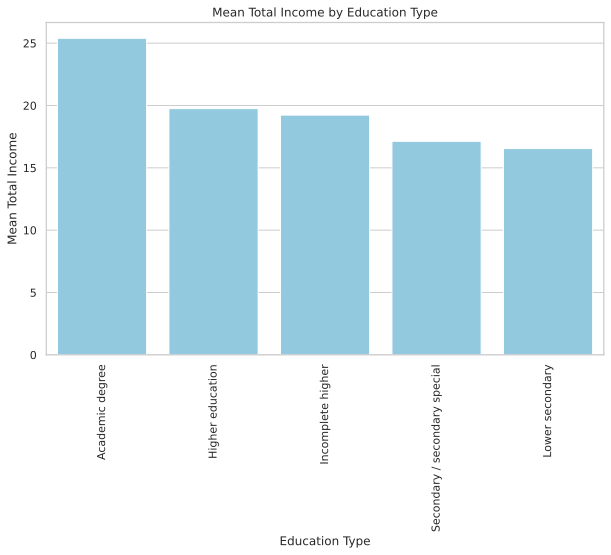

In [355]:
mean_income_by_EducationType = new_data.groupby('EducationType')['Income'].mean()
sorted_income = mean_income_by_EducationType.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# Use sorted series for both x and y axes
sns.barplot(
    x=sorted_income.index,
    y=sorted_income.values,
    color='skyblue'
)

plt.xlabel('Education Type')
plt.ylabel('Mean Total Income')
plt.title('Mean Total Income by Education Type')
plt.xticks(rotation=90)
plt.show()

In [356]:
new_data.loc[new_data['EducationType']=='Academic degree','EducationType']='Higher education'
iv, data=calc_iv(new_data,'EducationType','target')
ivtable.loc[ivtable['variable']=='EducationType','IV']=iv
data.head()

This variable's IV is: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: EducationType, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,EducationType,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,EducationType,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,EducationType,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,EducationType,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


####  Martial status

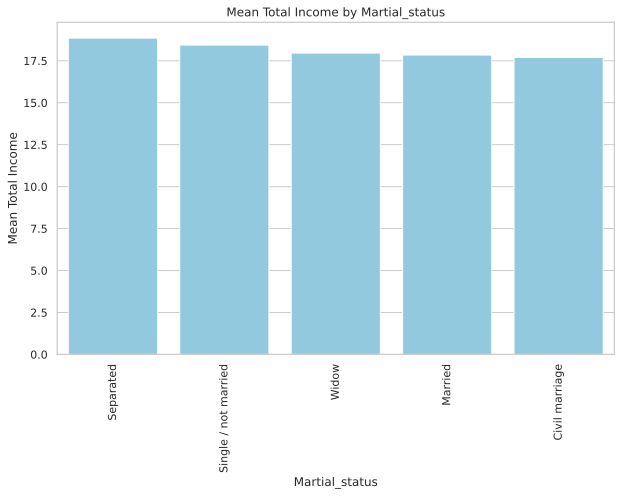

In [357]:
mean_income_by_Martial_status = new_data.groupby('Martial_status')['Income'].mean()
sorted_income = mean_income_by_Martial_status.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# Use sorted series for both x and y axes
sns.barplot(
    x=sorted_income.index,
    y=sorted_income.values,
    color='skyblue'
)

plt.xlabel('Martial_status')
plt.ylabel('Mean Total Income')
plt.title('Mean Total Income by Martial_status')
plt.xticks(rotation=90)
plt.show()

In [358]:
iv, data=calc_iv(new_data,'Martial_status','target')
ivtable.loc[ivtable['variable']=='Martial_status','IV']=iv
data.head()

This variable's IV is: 0.032004120494654835
Married                 18108
Single / not married     2846
Civil marriage           2133
Separated                1467
Widow                     580
Name: Martial_status, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Martial_status,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,Martial_status,Married,18108,17813,295,0.720458,0.016291,0.720824,0.699052,0.030670,0.000668
2,Martial_status,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,Martial_status,Single / not married,2846,2781,65,0.113233,0.022839,0.112536,0.154028,-0.313860,0.013023
4,Martial_status,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


## Correlation Matrix

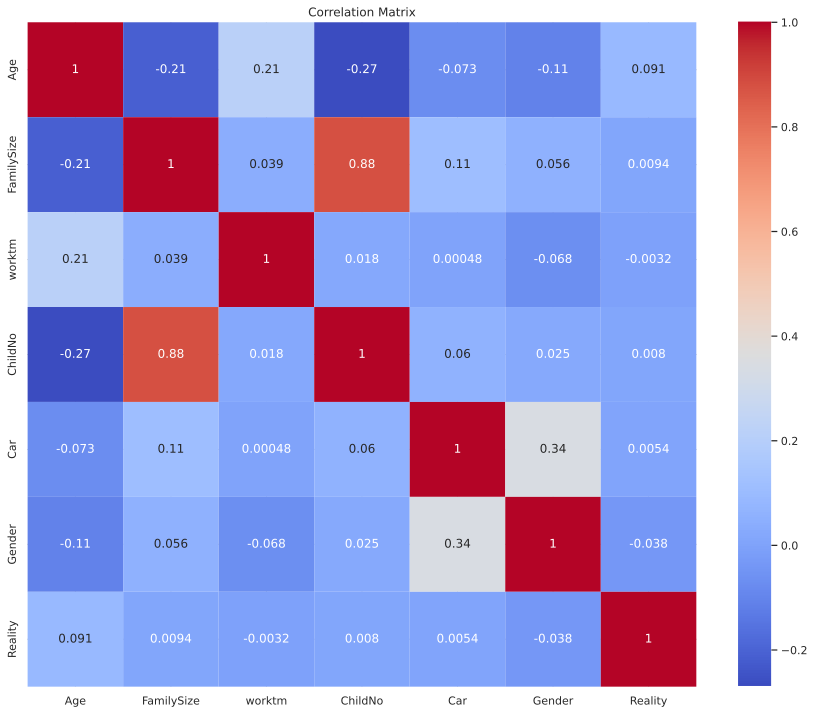

In [359]:
# Assuming new_data is your dataframe containing all the features
# Filter new_data to only include the specified columns
selected_features = [
     'Income', 'Age', 'FamilySize','worktm',
     'WorkPhone', 'Phone', 'Email',
    'ChildNo','Car','Gender','Reality'
]
filtered_data = new_data[selected_features]

# Compute correlation matrix for selected features
correlation_matrix = filtered_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [360]:
# Find highly correlated features
high_corr = set()  # Set to store highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Change the correlation threshold as needed
            colname = correlation_matrix.columns[i]
            high_corr.add(colname)

# Remove highly correlated features
df_dropped = new_data.drop(high_corr, axis=1)
num_deleted = len(new_data.columns) - len(df_dropped.columns)
deleted_features = list(set(new_data.columns) - set(df_dropped.columns))

# Print the number of deleted features and their names
print(f"Number of features deleted: {num_deleted}")
print(f"Deleted feature names: {', '.join(deleted_features)}")


Number of features deleted: 1
Deleted feature names: ChildNo


In [361]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'ChildNo', 'Income', 'IncomeType',
       'EducationType', 'Martial_status', 'HousingType', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'WorkPhone', 'Phone', 'Email',
       'OccupationType', 'FamilySize', 'begin_month', 'dep_value', 'target',
       'ChildNoegp', 'gp_Income', 'Age', 'gp_Age', 'worktm', 'gp_worktm',
       'famsizegp'],
      dtype='object')

## Convert dummy

In [362]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Convert columns to string data type if needed
columns_to_convert = ['famsizegp', 'gp_Income', 'gp_Age', 'gp_worktm', 'IncomeType',
                      'OccupationType', 'HousingType', 'EducationType', 'Martial_status']

for column in columns_to_convert:
    new_data[column] = new_data[column].astype(str)

# Create the encoder
encoder = OneHotEncoder()

# Fit and transform the data
new_data_encoded = encoder.fit_transform(new_data[columns_to_convert])

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(new_data_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_convert))

# Reset the index for joining
data_reset = new_data.reset_index(drop=True)
encoded_df_reset = encoded_df.reset_index(drop=True)

# Merge with main DataFrame based on a common key, e.g., index
New_df = pd.concat([data_reset, encoded_df_reset], axis=1)


## IV & WOE

In [363]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable


,variable,IV
11,worktmgp,0.098184
10,agegp,0.065935
8,Martial_status,0.032004
3,Reality,0.027441
1,Gender,0.025204
7,EducationType,0.010362
17,FamilySize,0.008126
9,HousingType,0.007328
16,OccupationType,0.00482
4,ChildNo,0.003713


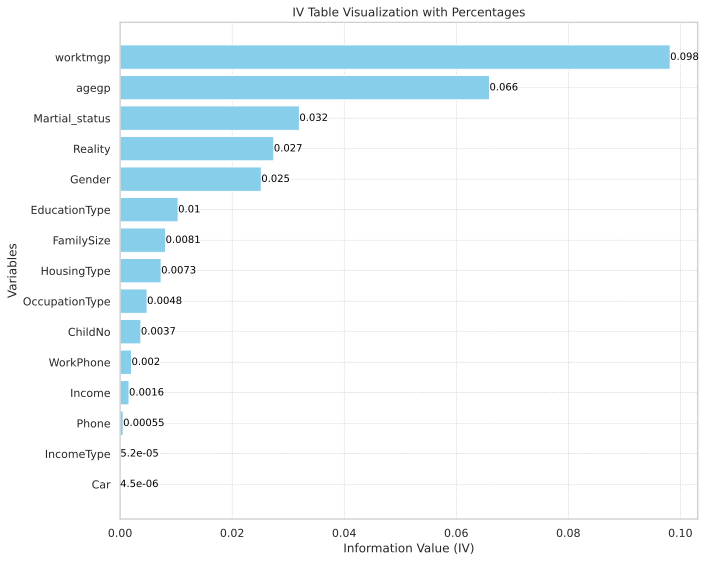

In [364]:
# Filter out rows with None IV values
ivtable_filtered = ivtable.dropna(subset=['IV'])

# Sort the filtered table
ivtable_filtered = ivtable_filtered.sort_values(by='IV', ascending=True)

# Visualization
plt.figure(figsize=(10, 8))  # Adjust size if necessary
bars = plt.barh(ivtable_filtered['variable'], ivtable_filtered['IV'], color='skyblue')

# Annotate bars with percentages
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2,
             f'{width:.2}',
             va='center',
             ha='left',
             fontsize=10,
             color='black')

plt.xlabel('Information Value (IV)')
plt.ylabel('Variables')
plt.title('IV Table Visualization with Percentages')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjust layout
plt.show()


In [365]:
New_df.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'ChildNo', 'Income', 'IncomeType',
       'EducationType', 'Martial_status', 'HousingType', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'WorkPhone', 'Phone', 'Email',
       'OccupationType', 'FamilySize', 'begin_month', 'dep_value', 'target',
       'ChildNoegp', 'gp_Income', 'Age', 'gp_Age', 'worktm', 'gp_worktm',
       'famsizegp', 'famsizegp_1.0', 'famsizegp_2.0', 'famsizegp_3more',
       'gp_Income_high', 'gp_Income_low', 'gp_Income_medium', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'gp_Age_medium',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_lowest', 'gp_worktm_medium',
       'IncomeType_Commercial associate', 'IncomeType_State servant',
       'IncomeType_Working', 'OccupationType_Laborwk',
       'OccupationType_hightecwk', 'OccupationType_officewk',
       'HousingType_Co-op apartment', 'HousingType_House / apartment',
       'HousingType_Municipal apartment', 

# Split Dataset

In [366]:
Y = New_df['target']
X = New_df[['Gender','Reality','famsizegp_1.0', 'famsizegp_2.0', 'famsizegp_3more',
       'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'gp_Age_medium',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_lowest', 'gp_worktm_medium',
       'OccupationType_Laborwk',
       'OccupationType_hightecwk', 'OccupationType_officewk',
       'HousingType_Co-op apartment', 'HousingType_House / apartment',
       'HousingType_Municipal apartment', 'HousingType_Office apartment',
       'HousingType_Rented apartment', 'HousingType_With parents',
       'EducationType_Higher education', 'EducationType_Incomplete higher',
       'EducationType_Lower secondary',
       'EducationType_Secondary / secondary special',
       'Martial_status_Civil marriage', 'Martial_status_Married',
       'Martial_status_Separated', 'Martial_status_Single / not married',
       'Martial_status_Widow']]

# Synthetic Minority Over-Sampling Technique(`SMOTE`)

In [367]:
Y = Y.astype(int)

In [368]:
X_SMOTE, Y_SMOTE = SMOTE().fit_resample(X, Y)

# Convert the numpy array to a pandas DataFrame with appropriate column names
X_SMOTE = pd.DataFrame(X_SMOTE, columns=X.columns)



In [369]:
# Extract feature names for reference
feature_names = X_SMOTE.columns.tolist()

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
scaled_X_SMOTE = scaler.fit_transform(X_SMOTE)

# Convert the scaled data back to a DataFrame with feature names
scaled_X_SMOTE = pd.DataFrame(scaled_X_SMOTE, columns=feature_names)

In [370]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X_SMOTE,Y_SMOTE,
                                                    stratify=Y_SMOTE,
                                                      test_size=0.3,
                                                    random_state = 0)

In [371]:
X_train.shape , X_test.shape

((34596, 33), (14828, 33))

# Algorithms

## Logistic Regression   

Train Result:
Accuracy Score: 63.37%
F1 Score: 64.59%
_______________________________________________
Test Result:
Accuracy Score: 63.55%
F1 Score: 64.93%
_______________________________________________
Classification Report:
                     0            1  accuracy     macro avg  weighted avg
precision     0.647050     0.625610  0.635487      0.636330      0.636330
recall        0.596169     0.674804  0.635487      0.635487      0.635487
f1-score      0.620569     0.649276  0.635487      0.634923      0.634923
support    7414.000000  7414.000000  0.635487  14828.000000  14828.000000
_______________________________________________


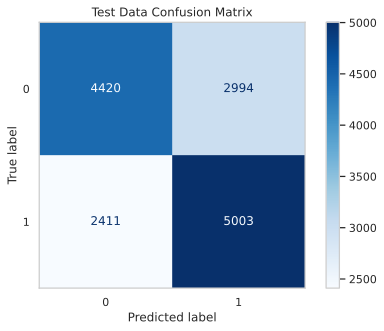

In [386]:
log_reg_model = LogisticRegression(random_state=42)

# Fit the model to the training data
log_reg_model.fit(X_train, y_train)

# Make predictions using the optimized logistic regression model on the train data and test data
y_train_pred_logreg = cross_val_predict(log_reg_model, X_train, y_train, cv=3)
y_test_pred_logreg = cross_val_predict(log_reg_model, X_test, y_test, cv=3)

print_score(y_train, y_train_pred_logreg, train=True)
print_score(y_test, y_test_pred_logreg, train=False)

lr_fscore= f1_score(y_test, y_test_pred_logreg)
lr_accuracy = accuracy_score(y_test, y_test_pred_logreg)
lr_recall = recall_score(y_test, y_test_pred_logreg, average='weighted')
lr_precision = precision_score(y_test, y_test_pred_logreg, average='weighted')

## Decision Tree

Train Result:
Accuracy Score: 92.55%
F1 Score: 92.68%
_______________________________________________
Test Result:
Accuracy Score: 91.68%
F1 Score: 91.84%
_______________________________________________
Classification Report:
                     0            1  accuracy     macro avg  weighted avg
precision     0.933989     0.900882  0.916779      0.917435      0.917435
recall        0.896952     0.936606  0.916779      0.916779      0.916779
f1-score      0.915096     0.918397  0.916779      0.916746      0.916746
support    7414.000000  7414.000000  0.916779  14828.000000  14828.000000
_______________________________________________


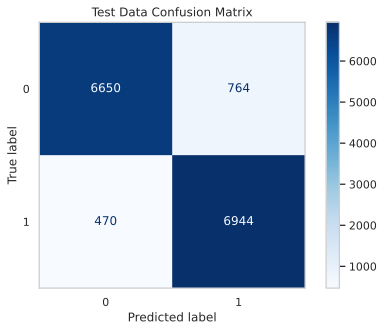

In [387]:
Dec_Tre_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
Dec_Tre_model.fit(X_train, y_train)

# Make predictions using the optimized Decision Tree Classifier model on the train data and test data
y_train_pred_DecTre = cross_val_predict(Dec_Tre_model, X_train, y_train, cv=3)
y_test_pred_DecTre = cross_val_predict(Dec_Tre_model, X_test, y_test, cv=3)

print_score(y_train, y_train_pred_DecTre, train=True)
print_score(y_test, y_test_pred_DecTre, train=False)

dt_fscore= f1_score(y_test, y_test_pred_DecTre)
dt_accuracy = accuracy_score(y_test, y_test_pred_DecTre)
dt_recall = recall_score(y_test, y_test_pred_DecTre, average='weighted')
dt_precision = precision_score(y_test, y_test_pred_DecTre, average='weighted')

## Random Forest   

Train Result:
Accuracy Score: 92.82%
F1 Score: 92.96%
_______________________________________________
Test Result:
Accuracy Score: 92.19%
F1 Score: 92.34%
_______________________________________________
Classification Report:
                     0            1  accuracy     macro avg  weighted avg
precision     0.939573     0.905602  0.921905      0.922587      0.922587
recall        0.901807     0.942002  0.921905      0.921905      0.921905
f1-score      0.920303     0.923443  0.921905      0.921873      0.921873
support    7414.000000  7414.000000  0.921905  14828.000000  14828.000000
_______________________________________________


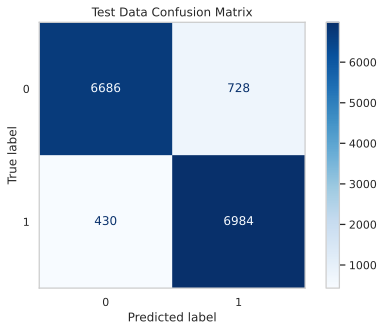

In [388]:
Ran_For_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
Ran_For_model.fit(X_train, y_train)

# Make predictions using the optimized Random Forest Classifier model on the train data and test data
y_train_pred_RanFor = cross_val_predict(Ran_For_model, X_train, y_train, cv=3)
y_test_pred_RanFor = cross_val_predict(Ran_For_model, X_test, y_test, cv=3)

print_score(y_train, y_train_pred_RanFor, train=True)
print_score(y_test, y_test_pred_RanFor, train=False)

rf_fscore= f1_score(y_test, y_test_pred_RanFor)
rf_accuracy = accuracy_score(y_test, y_test_pred_RanFor)
rf_recall = recall_score(y_test, y_test_pred_RanFor, average='weighted')
rf_precision = precision_score(y_test, y_test_pred_RanFor, average='weighted')

## SVM

Train Result:
Accuracy Score: 88.10%
F1 Score: 88.51%
_______________________________________________
Test Result:
Accuracy Score: 86.08%
F1 Score: 86.74%
_______________________________________________
Classification Report:
                     0            1  accuracy     macro avg  weighted avg
precision     0.900329     0.828382  0.860804      0.864356      0.864356
recall        0.811438     0.910170  0.860804      0.860804      0.860804
f1-score      0.853575     0.867352  0.860804      0.860464      0.860464
support    7414.000000  7414.000000  0.860804  14828.000000  14828.000000
_______________________________________________


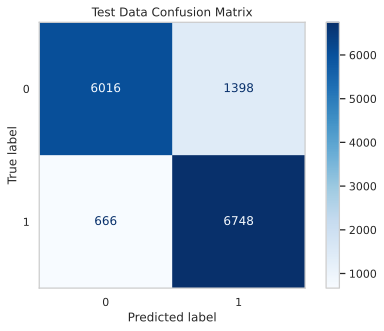

In [389]:
SVM_model = svm.SVC(random_state=42)

# Fit the model to the training data
SVM_model.fit(X_train, y_train)

# Make predictions using the optimized SVM model on the train data and test data
y_train_pred_SVM = cross_val_predict(SVM_model, X_train, y_train, cv=3)
y_test_pred_SVM = cross_val_predict(SVM_model, X_test, y_test, cv=3)

print_score(y_train, y_train_pred_SVM, train=True)
print_score(y_test, y_test_pred_SVM, train=False)

SVM_fscore= f1_score(y_test, y_test_pred_SVM)
SVM_accuracy = accuracy_score(y_test, y_test_pred_SVM)
SVM_recall = recall_score(y_test, y_test_pred_SVM, average='weighted')
SVM_precision = precision_score(y_test, y_test_pred_SVM, average='weighted')

## LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17298, number of negative: 17298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6586
[LightGBM] [Info] Number of data points in the train set: 34596, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11532, number of negative: 11532
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6299
[Light

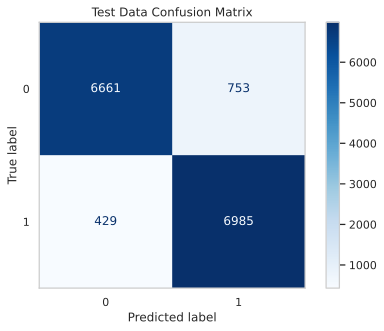

In [390]:
lgbm_Model = LGBMClassifier(random_state=42)

# Fit the model to the training data
lgbm_Model.fit(X_train, y_train)

# Make predictions using the optimized LGBM Classifier on the train data and test data
y_train_pred_lgbm = cross_val_predict(lgbm_Model, X_train, y_train, cv=3)
y_test_pred_lgbm= cross_val_predict(lgbm_Model, X_test, y_test, cv=3)

print_score(y_train, y_train_pred_lgbm, train=True)
print_score(y_test, y_test_pred_lgbm, train=False)

LGBM_fscore = f1_score(y_test, y_test_pred_lgbm)
LGBM_accuracy = accuracy_score(y_test, y_test_pred_lgbm)
LGBM_recall = recall_score(y_test, y_test_pred_lgbm, average='weighted')
LGBM_precision = precision_score(y_test, y_test_pred_lgbm, average='weighted')

## Xgboost

Train Result:
Accuracy Score: 92.75%
F1 Score: 92.84%
_______________________________________________
Test Result:
Accuracy Score: 92.53%
F1 Score: 92.69%
_______________________________________________
Classification Report:
                     0            1  accuracy     macro avg  weighted avg
precision     0.944217     0.908009  0.925344      0.926113      0.926113
recall        0.904100     0.946588  0.925344      0.925344      0.925344
f1-score      0.923724     0.926897  0.925344      0.925310      0.925310
support    7414.000000  7414.000000  0.925344  14828.000000  14828.000000
_______________________________________________


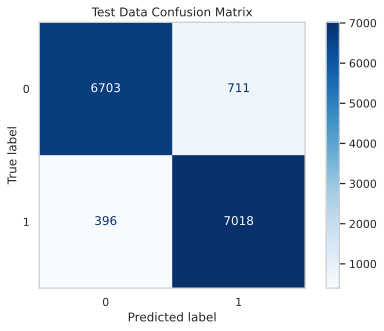

In [391]:
xgb_classifier = XGBClassifier(random_state=42)

# Fit the model to the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions using the optimized LGBM Classifier on the train data and test data
y_train_pred_xgb = cross_val_predict(xgb_classifier, X_train, y_train, cv=3)
y_test_pred_xgb= cross_val_predict(xgb_classifier, X_test, y_test, cv=3)

print_score(y_train, y_train_pred_xgb, train=True)
print_score(y_test, y_test_pred_xgb, train=False)

XGB_fscore= f1_score(y_test, y_test_pred_xgb)
XGB_accuracy = accuracy_score(y_test, y_test_pred_xgb)
XGB_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')
XGB_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

# Summary result for Models

In [392]:
models = ['Random Forest', 'Decision Tree', 'Support Vector Machine', 'Logistic Regression', 'XGBoost', 'LGBM']
f1_scores = [rf_fscore, dt_fscore, SVM_fscore, lr_fscore, XGB_fscore, LGBM_fscore ]
accuracies = [rf_accuracy, dt_accuracy, SVM_accuracy, lr_accuracy, XGB_accuracy, LGBM_accuracy]
recall = [rf_recall, dt_recall, SVM_recall, lr_recall, XGB_recall, LGBM_recall]
precision= [rf_precision, dt_precision, SVM_precision, lr_precision, XGB_precision, LGBM_precision]


df_second_table = create_summary(models, f1_scores, accuracies,recall, precision)
# Apply border style to the dataframe for display
styled_table = df_second_table.style.highlight_max(subset=['Accuracy', 'F1 Score', 'Recall', 'Precision'], color='green')
styled_table


,Models,Accuracy,F1 Score,Recall,Precision
0,Random Forest,0.922%,0.923%,0.922%,0.923%
1,Decision Tree,0.917%,0.918%,0.917%,0.917%
2,Support Vector Machine,0.861%,0.867%,0.861%,0.864%
3,Logistic Regression,0.635%,0.649%,0.635%,0.636%
4,XGBoost,0.925%,0.927%,0.925%,0.926%
5,LGBM,0.920%,0.922%,0.920%,0.921%


# After Feature selection & HyperParamters

## Xgboost

In [393]:
best_score = 0
best_features = []

# Loop through a range of feature counts to find the best set of features
for num_features in range(1, len(X.columns) + 1):
    # Initialize XGBoost classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # You can add more parameters based on your requirements

    # Initialize RFE with the current number of features
    rfe = RFE(model, n_features_to_select=num_features)

    # Fit RFE
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X.columns[rfe.support_]

    # Train a model using the selected features
    model.fit(X_train[selected_features], y_train)

    # Predict on the test set
    y_pred = model.predict(X_test[selected_features])

    # Calculate accuracy score
    score = accuracy_score(y_test, y_pred)

    # Update best score and best features if the current model is better
    if score > best_score:
        best_score = score
        best_features = selected_features.tolist()

print("Best Features:", best_features)
print("Best Accuracy Score:", best_score)


Best Features: ['Gender', 'Reality', 'famsizegp_1.0', 'famsizegp_2.0', 'famsizegp_3more', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'gp_Age_medium', 'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_lowest', 'gp_worktm_medium', 'OccupationType_Laborwk', 'OccupationType_hightecwk', 'OccupationType_officewk', 'HousingType_House / apartment', 'HousingType_With parents', 'EducationType_Higher education', 'EducationType_Incomplete higher', 'EducationType_Lower secondary', 'EducationType_Secondary / secondary special', 'Martial_status_Civil marriage', 'Martial_status_Married', 'Martial_status_Separated', 'Martial_status_Single / not married', 'Martial_status_Widow']
Best Accuracy Score: 0.9283113029403831


In [394]:
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

In [ ]:
# Hyperparameters grid for XGBClassifier
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 20],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.5, 0.7, 1.0]
}

# Initialize the XGBClassifier with some default parameters
xgb_model = XGBClassifier(random_state=42)

# Initialize GridSearchCV with the XGBClassifier, hyperparameter grid, and scoring metric (e.g., accuracy)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the training data (using the best features)
grid_search.fit(X_train_best, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best XGB Model:", best_xgb_model)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.5}
Best XGB Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [ ]:
# Make predictions using the optimized LGBM Classifier on the test data
y_test_pred_xgb= cross_val_predict(best_xgb_model, X_test_best, y_test, cv=3)

print_score(y_test, y_test_pred_xgb, train=False)

XGB_fscore= f1_score(y_test, y_test_pred_xgb)
XGB_accuracy = accuracy_score(y_test, y_test_pred_xgb)
XGB_recall = recall_score(y_test, y_test_pred_xgb, average='weighted')
XGB_precision = precision_score(y_test, y_test_pred_xgb, average='weighted')

In [ ]:
models = ['Random Forest', 'Decision Tree', 'Support Vector Machine', 'Logistic Regression', 'XGBoost', 'LGBM']
f1_scores = [rf_fscore, dt_fscore, SVM_fscore, lr_fscore, XGB_fscore, LGBM_fscore ]
accuracies = [rf_accuracy, dt_accuracy, SVM_accuracy, lr_accuracy, XGB_accuracy, LGBM_accuracy]
recall = [rf_recall, dt_recall, SVM_recall, lr_recall, XGB_recall, LGBM_recall]
precision= [rf_precision, dt_precision, SVM_precision, lr_precision, XGB_precision, LGBM_precision]


df_second_table = create_summary(models, f1_scores, accuracies,recall, precision)
# Apply border style to the dataframe for display
styled_table = df_second_table.style.highlight_max(subset=['Accuracy', 'F1 Score', 'Recall', 'Precision'], color='green')
styled_table
